In [1]:
%matplotlib inline

import numpy as np

import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection, PolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from tqdm import tqdm_notebook as tqdm

import gridded

print('gridded version: {}'.format(gridded.__version__))
print('cartopy config: {}'.format(cartopy.config))

gridded version: 0.1.0
cartopy config: {'repo_data_dir': 'c:\\python35\\lib\\site-packages\\cartopy\\data', 'downloaders': {('shapefiles', 'gshhs'): <cartopy.io.shapereader.GSHHSShpDownloader object at 0x0000000007F14B70>, ('shapefiles', 'natural_earth'): <cartopy.io.shapereader.NEShpDownloader object at 0x0000000007EFDEB8>}, 'data_dir': 'C:\\Users\\hoek.HKV\\.local\\share\\cartopy', 'pre_existing_data_dir': ''}


c:\python35\lib\site-packages\matplotlib\ticker.py:1856: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
url = (r'\\HKVHEAD001\Projects\pr\3744_10\delft3d_fm\tst48a\DFM_OUTPUT_tst48a\tst48a_map.nc')
ds = gridded.Dataset(url)

In [3]:
# now we retrieve four different info from the read nc-file
# - type of grid
# - number of nodes
# - number of faces
# - vertices per face
print(ds.grid.info)

UGrid object:
Number of nodes: 324847
Number of faces: 324051 with 4 vertices per face


In [4]:
# the nc-file is a Unstructered Grid with 54925 number of nodes 
# and 53597 number of faces where each face has 4 vertices

In [5]:
# next, lets check the variables within the dataset"
print("variables available and their standard names:\n")
for name, var in ds.variables.items():
    try:
        print(name, ":", var.attributes['standard_name'])
    except KeyError:
        pass

variables available and their standard names:

mesh2d_ucyq : ucyq_velocity
mesh2d_ucy : northward_water_velocity
mesh2d_taus : 
mesh2d_windx : eastward_wind
mesh2d_flowelem_ba : cell_area
mesh2d_czs : 
mesh2d_s0 : sea_surface_height
mesh2d_Numlimdt : 
mesh2d_waterdepth : sea_floor_depth_below_sea_surface
mesh2d_ucmag : sea_water_speed
mesh2d_node_z : altitude
mesh2d_Patm : surface_air_pressure
mesh2d_ucxq : ucxq_velocity
mesh2d_flowelem_bl : altitude
mesh2d_s1 : sea_surface_height
mesh2d_ucx : eastward_sea_water_velocity
mesh2d_windy : northward_wind


In [6]:
# we are interested in the sea surface height:
ssh = ds.variables['mesh2d_waterdepth']

In [7]:
ssh.attributes

{'_FillValue': -999.0,
 'cell_methods': 'nmesh2d_face: mean',
 'coordinates': 'mesh2d_face_x mesh2d_face_y',
 'grid_mapping': 'wgs84',
 'location': 'face',
 'long_name': 'Water depth at pressure points',
 'mesh': 'mesh2d',
 'standard_name': 'sea_floor_depth_below_sea_surface',
 'units': 'm'}

In [8]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

# the first and last step of this variable are at?
print("minimum time:", ssh.time.min_time)
print("manimum time:", ssh.time.max_time)
time_arr = ssh.time.get_time_array()
print("timestep (day, hours, minutes):", days_hours_minutes(time_arr[1] - time_arr[0]))
print("total no. of timesteps:",len(time_arr))

minimum time: 2017-11-19 00:00:00
manimum time: 2017-11-23 00:00:00
timestep (day, hours, minutes): (0, 6, 0)
total no. of timesteps: 29


The dataset has nodes (or vertexes) representing a point in a 2D space, the faces (or polygons) correspond to a plane enclosed by a set of edges. Note that the dataset does might not contain the edges! If that is the case ee need to compute those:

In [9]:
try:
    _ = ssh.grid.edges.shape
    print('edges exist')
    print(_)
except AttributeError:
    print('edges not exist, set first')
    ssh.grid.build_edges()

edges exist
(649465, 2)


Lets get the data coressponding the start-time, this is used to set the colors of the patches. The `.at()` functions request, the coordinates to be queries (`nodes`) and the time at which to query these points

## CHANGE IS HERE

In [10]:
time_interest = ssh.time.max_time
data_coloring = ssh.data[-1,:]#ssh.at(ssh.grid.nodes, time_interest)

In [11]:
len(data_coloring)

324051

For the mesh, we get multiple variables from the grid object. Namely, the `node_lon`, `node_lat`, `faces`, `edges` and `nodes`.
- `node_lon` is 1D array with longitude values
- `node_lat` is 1D array with latitude values
- `faces` is 2D array, where each row contains the vertices of the face/patch
- `edges` is 2D array, where each row contains the first vertice of the  the face/patch
- `nodes` is 2D array, where each row contains the coordinate corresponding the vertice

In [12]:
# note that we are working with just the variable object now...
lon = ssh.grid.node_lon
lat = ssh.grid.node_lat
faces = ssh.grid.faces
edges = ssh.grid.edges
nodes = ssh.grid.nodes

As can be seen, in this grid each face contains 4 vertices

In [13]:
print('vertices in face',faces[0])
print('number of faces',len(faces))

vertices in face [52650 52751 52752 52651]
number of faces 324051


In [14]:
ssh.attributes['_FillValue']

-999.0

In [15]:
faces_masked = np.ma.masked_where(faces == ssh.attributes['_FillValue'], faces)

(array([127322., 128636., 128208., 129950., 129650., 130120., 129515.,
        129225., 129644., 129628.]),
 array([     0. ,  32484.6,  64969.2,  97453.8, 129938.4, 162423. ,
        194907.6, 227392.2, 259876.8, 292361.4, 324846. ]),
 <a list of 10 Patch objects>)

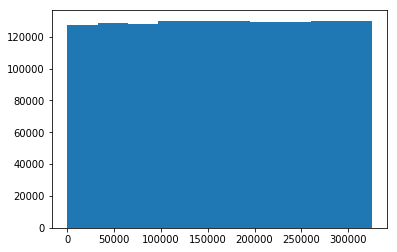

In [18]:
plt.hist(faces_masked.ravel())

In [23]:
for idx, face in enumerate(faces):
    if face.min()<0 :
        print(idx, face)

90592 [118215 260195 180842   -999]
90593 [ 86811 142762 260195   -999]
90697 [118215 180842 192618   -999]
90699 [ 45758 192618 118403   -999]
91377 [156551 181021 209557   -999]
91378 [ 86811 209557 142762   -999]
91379 [142762 180842 260195   -999]
91484 [118403 192618 180842   -999]
91485 [ 45758 118403 277201   -999]
91487 [156647 277201 180843   -999]
92164 [156551 277145 181021   -999]
92165 [ 45845 118309 277145   -999]
92166 [142762 209557 181021   -999]
92276 [118403 180843 277201   -999]
92277 [156647 180843 209613   -999]
92279 [ 86937 209613 142584   -999]
92955 [118118 181020 192562   -999]
92956 [ 45845 192562 118309   -999]
92957 [118309 181021 277145   -999]
93071 [142584 209613 180843   -999]
93072 [ 86937 142584 260251   -999]
93074 [118312 260251 180666   -999]
93751 [118118 260138 181020   -999]
93752 [ 86685 142941 260138   -999]
93753 [118309 192562 181020   -999]
93871 [142584 180666 260251   -999]
93872 [118312 180666 192674   -999]
93874 [ 45671 192674 118495 

110874 [143868 181934 259843   -999]
111051 [118948 192942 179782   -999]
111052 [ 45236 118948 277526   -999]
111054 [157194 277526 179783   -999]
111358 [149150 187411 274232   -999]
111360 [149153 206660 187410   -999]
111361 [ 78744 151950 206660   -999]
111362 [151950 206658 187411   -999]
111365 [149153 187410 274234   -999]
111366 [109194 274234 149154   -999]
111682 [155963 276791 182131   -999]
111683 [ 46382 117720 276791   -999]
111684 [143868 209204 182131   -999]
111863 [118948 179783 277526   -999]
111864 [157194 179783 209936   -999]
111866 [ 87662 209936 141514   -999]
112169 [151950 187410 206660   -999]
112171 [149155 274235 187415   -999]
112172 [109194 149154 274235   -999]
112173 [149154 274234 187410   -999]
112176 [149155 187415 206661   -999]
112177 [ 78879 206661 151989   -999]
112488 [117523 182130 192210   -999]
112489 [ 46382 192210 117720   -999]
112490 [117720 182131 276791   -999]
112671 [141514 209936 179783   -999]
112672 [ 87662 141514 260572   -999]
1

125836 [149189 206687 187446   -999]
125837 [ 80010 152354 206687   -999]
125838 [152354 206685 187447   -999]
125841 [149189 187446 274261   -999]
125842 [109203 274261 149190   -999]
126078 [117127 259547 182938   -999]
126079 [ 85401 144883 259547   -999]
126080 [117322 191974 182938   -999]
126293 [140808 178905 260777   -999]
126294 [119216 178905 193198   -999]
126296 [ 44801 193198 119391   -999]
126637 [152354 187446 206687   -999]
126639 [149191 274262 187451   -999]
126640 [109203 149190 274262   -999]
126641 [149190 274261 187446   -999]
126644 [149191 187451 206688   -999]
126645 [ 80152 206688 152402   -999]
126878 [155469 183147 208906   -999]
126879 [ 85401 208906 144883   -999]
126880 [144883 182938 259547   -999]
127093 [119391 193198 178905   -999]
127094 [ 44801 119391 277787   -999]
127096 [157636 277787 178906   -999]
127442 [149190 187451 274262   -999]
127444 [149193 206690 187450   -999]
127445 [ 80152 152402 206690   -999]
127446 [152402 206688 187451   -999]
1

141170 [109212 149226 274289   -999]
141171 [149226 274288 187482   -999]
141174 [149227 187487 206715   -999]
141175 [ 81395 206715 152892   -999]
141332 [116621 184003 191689   -999]
141333 [ 47238 191689 116826   -999]
141334 [116826 184004 276259   -999]
141555 [139926 210413 178205   -999]
141556 [ 88727 139926 261046   -999]
141558 [119663 261046 178026   -999]
141892 [ 77131 109983 113366   -999]
141893 [ 77328 109983 151683   -999]
141895 [ 49725 151683  77228   -999]
141976 [149226 187487 274289   -999]
141978 [149229 206717 187486   -999]
141979 [ 81395 152892 206717   -999]
141980 [152892 206715 187487   -999]
141983 [149229 187486 274291   -999]
141984 [109213 274291 149230   -999]
142137 [116621 259260 184003   -999]
142138 [ 84749 145959 259260   -999]
142139 [116826 191689 184003   -999]
142361 [139926 178026 261046   -999]
142362 [119663 178026 193466   -999]
142364 [ 44366 193466 119842   -999]
142699 [ 77228 151683 109983   -999]
142700 [ 49725  77228 113371   -999]
1

167585 [ 43667 120574 278537   -999]
167587 [158807 278537 176607   -999]
167796 [54909 54910 75007  -999]
167797 [54768 54910 75034  -999]
167799 [54769 75034 54911  -999]
167914 [ 79134 110000 113817   -999]
167915 [ 79417 110000 152145   -999]
167917 [ 49742 152145  79274   -999]
167989 [153702 206751 187535   -999]
168036 [154193 275763 186117   -999]
168037 [ 48154 115935 275763   -999]
168038 [147855 208179 186117   -999]
168287 [120574 176607 278537   -999]
168288 [158807 176607 210941   -999]
168290 [ 89810 210941 138319   -999]
168497 [54910 54911 75034  -999]
168498 [54769 54911 75063  -999]
168500 [54770 75063 54912  -999]
168615 [ 79274 152145 110000   -999]
168616 [ 49742  79274 113863   -999]
168618 [ 79559 113863 110001   -999]
168689 [ 82958 206751 153702   -999]
168697 [115363 258499 187297   -999]
168698 [ 82958 149277 258499   -999]
168699 [115363 187297 190932   -999]
168700 [ 48661 190932 115517   -999]
168735 [115766 186116 191203   -999]
168736 [ 48154 191203 115

196471 [54815 54957 78627  -999]
196473 [54816 78627 54958  -999]
196569 [ 82427 153461 110023   -999]
196570 [ 49765  82427 115195   -999]
196572 [ 82684 115195 110024   -999]
196887 [121686 194655 174594   -999]
196888 [ 42648 121686 279269   -999]
196890 [159919 279269 174595   -999]
197005 [54957 54958 78627  -999]
197006 [54816 54958 78762  -999]
197008 [54817 78762 54959  -999]
197104 [ 82427 110024 115195   -999]
197105 [ 82684 110024 153533   -999]
197107 [ 49766 153533  82555   -999]
197422 [121686 174595 279269   -999]
197423 [159919 174595 211673   -999]
197425 [ 91281 211673 136301   -999]
197538 [54958 54959 78762  -999]
197539 [54817 54959 78899  -999]
197541 [54818 78899 54960  -999]
197637 [ 82555 153533 110024   -999]
197638 [ 49766  82555 115268   -999]
197640 [ 82811 115268 110025   -999]
197954 [136301 211673 174595   -999]
197955 [ 91281 136301 262293   -999]
197957 [121598 262293 174426   -999]
198069 [54959 54960 78899  -999]
198070 [54818 54960 79039  -999]
1980

222051 [122771 172400 279785   -999]
222052 [161000 172400 212189   -999]
222054 [ 92716 212189 134078   -999]
222118 [50869 84667 50966  -999]
222119 [50868 50869 84806  -999]
222121 [50771 84806 50772  -999]
222176 [ 47972  86770 147460   -999]
222178 [ 86895 108583 147221   -999]
222179 [ 47870 147221  86894   -999]
222180 [ 47870 147461  86770   -999]
222183 [ 86895 147222 108583   -999]
222184 [ 47768  87020 147222   -999]
222563 [134078 212189 172400   -999]
222564 [ 92716 134078 262797   -999]
222566 [122684 262797 172197   -999]
222629 [50772 84806 50869  -999]
222630 [50771 50772 84941  -999]
222632 [50674 84941 50675  -999]
222687 [ 47870  86895 147221   -999]
222689 [ 87021 108509 146982   -999]
222690 [ 47768 146982  87020   -999]
222691 [ 47768 147222  86895   -999]
222694 [ 87021 146983 108509   -999]
222695 [ 47665  87142 146983   -999]
223074 [134078 172197 262797   -999]
223075 [122684 172197 195214   -999]
223077 [ 41490 195214 122860   -999]
223140 [50675 84941 50772

244354 [46698 89872 46792  -999]
244355 [46697 46698 89995  -999]
244357 [46603 89995 46604  -999]
244412 [ 44119  91850 139269   -999]
244414 [ 91970 105951 139091   -999]
244415 [ 44031 139091  91969   -999]
244416 [ 44031 139270  91850   -999]
244419 [ 91970 139092 105951   -999]
244420 [ 43944  92088 139092   -999]
244846 [123788 195414 170125   -999]
244847 [ 40553 123788 280005   -999]
244849 [162006 280005 170126   -999]
244903 [46604 89995 46698  -999]
244904 [46603 46604 90118  -999]
244906 [46510 90118 46511  -999]
244961 [ 44031  91970 139091   -999]
244963 [ 92089 105892 138912   -999]
244964 [ 43944 138912  92088   -999]
244965 [ 43944 139092  91970   -999]
244968 [ 92089 138913 105892   -999]
244969 [ 43857  92207 138913   -999]
245393 [123788 170126 280005   -999]
245394 [162006 170126 212409   -999]
245396 [ 94050 212409 131788   -999]
245450 [46511 90118 46604  -999]
245451 [46510 46511 90241  -999]
245453 [46417 90241 46418  -999]
245508 [ 43944  92089 138912   -999]


256827 [131038 169173 195440   -999]
256985 [131124 169264 263088   -999]
256986 [103361 263088 131125   -999]
256987 [131124 195505 169264   -999]
256988 [ 93448 123240 195505   -999]
256989 [131122 263086 169257   -999]
256990 [103361 131125 263086   -999]
256991 [131122 169257 195503   -999]
256992 [ 93329 195503 123150   -999]
256993 [131129 263091 169268   -999]
256994 [123328 169268 195508   -999]
256995 [131129 169261 263089   -999]
256996 [123240 195506 169261   -999]
257106 [44485 92893 44572  -999]
257107 [44484 44485 93011  -999]
257109 [44397 93011 44398  -999]
257164 [ 41969  94882 134944   -999]
257166 [ 95008 104512 134757   -999]
257167 [ 41879 134757  95007   -999]
257168 [ 41879 134945  94882   -999]
257171 [ 95008 134758 104512   -999]
257172 [ 41789  95133 134758   -999]
 [122712 195488 169237   -999]
259656 [43959 93605 44046  -999]
259657 [43958 43959 93729  -999]
259659 [43871 93729 43872  -999]
259714 [ 41419  95639 133754   -999]
259716 [ 95766 104125 133548   

267325 [ 39729 129990  97813   -999]
267327 [ 97814 102993 129990   -999]
267361 [41984 96500 42073  -999]
267362 [41983 41984 96626  -999]
267364 [41893 96626 41894  -999]
267630 [ 39729  97814 129990   -999]
267631 [ 97814 129991 102993   -999]
267633 [ 39635  97918 129991   -999]
267667 [41894 96626 41984  -999]
267668 [41893 41894 96751  -999]
267670 [41803 96751 41804  -999]
267935 [ 39635 129991  97814   -999]
267936 [ 39635 129782  97918   -999]
267938 [ 97919 102927 129782   -999]
267971 [41804 96751 41894  -999]
267972 [41803 41804 96874  -999]
267974 [41711 96874 41712  -999]
268239 [ 39635  97919 129782   -999]
268240 [ 97919 129783 102927   -999]
268242 [ 39541  98021 129783   -999]
268275 [41712 96874 41804  -999]
268276 [41711 41712 96995  -999]
268278 [41619 96995 41620  -999]
268541 [ 39541 129783  97919   -999]
268542 [ 39541 129574  98021   -999]
268544 [ 98022 102861 129574   -999]
268577 [41620 96995 41712  -999]
268578 [41619 41620 97114  -999]
268580 [41526 97114 

285560 [ 37952 125263  96338   -999]
285561 [ 96588 101743 163613   -999]
285562 [ 96463 125323 101743   -999]
285637 [ 36184 100557  36274   -999]
285638 [ 36183  36273 100557   -999]
285639 [ 36184 100568  36185   -999]
285732 [ 96337 163493 101741   -999]
285733 [ 37952  96338 163493   -999]
285734 [ 96337 101741 125201   -999]
285735 [ 37951 125201  96213   -999]
285736 [ 96463 101742 163554   -999]
285737 [ 96338 125263 101742   -999]
285812 [ 36183 100544  36273   -999]
285813 [ 36182  36272 100544   -999]
285814 [ 36183 100557  36184   -999]
285903 [ 96212 163430 101740   -999]
285904 [ 37951  96213 163430   -999]
285905 [ 96212 101740 125137   -999]
285906 [ 37950 125137  96088   -999]
285907 [ 96338 101741 163493   -999]
285908 [ 96213 125201 101741   -999]
285983 [ 36182 100529  36272   -999]
285984 [ 36181  36271 100529   -999]
285985 [ 36182 100544  36183   -999]
286071 [ 96087 163365 101739   -999]
286072 [ 37950  96088 163365   -999]
286073 [ 96087 101739 125071   -999]
2

In [25]:
faces[90592]

array([118215, 260195, 180842,   -999])

In [27]:
faces_masked[90592].compressed()

array([118215, 260195, 180842])

In [28]:
faces_masked2 = faces_masked[~faces_masked.mask]

In [30]:
faces_masked2[90592]

115636

And the nodes contain the coordinates

In [ ]:
print('coordinate of vertice',nodes[0])
print('number of nodes',len(nodes))

We use the `nodes` variable to get the corresponding point coordinates of each vertice in a face

In [ ]:
squares = [nodes[face] for face in faces_masked]

Now each face is a combination of four coordinates

In [ ]:
squares[0]

In [ ]:
len(squares)

Prepare faces for matplotlib, this means the defining function for faces

In [ ]:
def faces_plot(x,y, faces, colors, ax=None, **kwargs):
    if not ax: ax=plt.gca()
    xy = np.c_[x,y]
    verts=xy[faces]
    pc = PolyCollection(verts, **kwargs)
    pc.set_array(colors)
    ax.add_collection(pc)
    ax.autoscale()
    return pc

And plot using cartopy

In [ ]:
def make_map(lon, lat, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15,8),
                           subplot_kw=dict(projection=projection))

    lonmin=6.3
    lonmax=6.33
    latmin=53.506
    latmax=53.53    
    #ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.coastlines(resolution='10m')
    
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [ ]:
# create a map
# fig, ax = make_map(lon, lat)

fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(
    projection=ccrs.PlateCarree()))

lonmin = 6.3
lonmax = 6.33
latmin = 53.506
latmax = 53.53
#ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

# add patches and set extent
# ax.add_collection(collection)

pc = faces_plot(lon, lat, faces_masked, data_coloring, ax=None,
                cmap='viridis', color="", facecolor="None")

# prepare a location for a colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

# add the figure and colorbar
fig.add_axes(ax_cb)
cbar = plt.colorbar(pc, cax=ax_cb)

ax.set_title('{} ({})'.format(
    ssh.attributes['long_name'], time_interest.strftime("%B %d, %Y")))
cbar.ax.set_ylabel(ssh.attributes['units'])
ax.set_extent([lonmin, lonmax, latmin, latmax])

ax.coastlines(resolution='10m')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.show()